In [246]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np
import warnings
warnings.simplefilter(action= 'ignore', category=FutureWarning)


from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt



s3= boto3.resource('s3')
bucket_name= 'morgangant-bata-445-bucket'
bucket= s3.Bucket(bucket_name)

file_key1= 'churn-bigml-80.csv'
file_key2= 'churn-bigml-20.csv'


bucket_object1= bucket.Object(file_key1)
file_object1= bucket_object1.get()
file_content_stream1 = file_object1.get('Body')

bucket_object2= bucket.Object(file_key2)
file_object2 = bucket_object2.get()
file_content_stream2 = file_object2.get('Body')

#reading the datefile
telecom_train = pd.read_csv(file_content_stream1)
telecom_test= pd.read_csv(file_content_stream2)

In [2]:
telecom_train.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
telecom_test.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [247]:
telecom_train= pd.DataFrame(telecom_train)
telecom_test= pd.DataFrame(telecom_test)

In [248]:
#Changing Churn yes/no to 1/0
telecom_train['Churn'].replace(['Yes', 'No'], [1,0], inplace= True)
telecom_test['Churn'].replace(['Yes', 'No'], [1,0], inplace= True)

#Changing International_plan yes/no to 1/0
telecom_train['International_plan'].replace(['Yes', 'No'], [1,0], inplace= True)
telecom_test['International_plan'].replace(['Yes', 'No'], [1,0], inplace= True)

#Changing Voice_mail_plan yes/no to 1/0
telecom_train['Voice_mail_plan'].replace(['Yes', 'No'], [1,0], inplace= True)
telecom_test['Voice_mail_plan'].replace(['Yes', 'No'], [1,0], inplace= True)

#Creating variable Total_charge
telecom_train= telecom_train.assign(total_charge= telecom_train['Total_day_charge'] + telecom_train['Total_eve_charge'] + telecom_train['Total_night_charge']+ telecom_train['Total_intl_charge'])
telecom_test= telecom_test.assign(total_charge= telecom_test['Total_day_charge'] + telecom_test['Total_eve_charge'] + telecom_test['Total_night_charge']+ telecom_test['Total_intl_charge'])

In [249]:
telecom_train= telecom_train.drop(columns= ['State','Area_code', 'Number_vmail_messages', 'Total_day_minutes', 'Total_day_calls', 'Total_day_charge', 'Total_eve_minutes', 'Total_eve_calls','Total_eve_charge', 'Total_night_minutes', 'Total_night_calls', 'Total_night_charge', 'Total_intl_minutes', 'Total_intl_calls', 'Total_intl_charge'], axis=1)
telecom_test= telecom_test.drop(columns= ['State','Area_code', 'Number_vmail_messages', 'Total_day_minutes', 'Total_day_calls', 'Total_day_charge', 'Total_eve_minutes', 'Total_eve_calls','Total_eve_charge', 'Total_night_minutes', 'Total_night_calls', 'Total_night_charge', 'Total_intl_minutes', 'Total_intl_calls', 'Total_intl_charge'], axis=1)

In [97]:
telecom_test.head()

,Account_length,International_plan,Voice_mail_plan,Customer_service_calls,Churn,total_charge
0,117,0,0,1,False,73.32
1,65,0,0,4,True,54.20
2,161,0,0,4,True,92.29
3,111,0,0,2,False,41.05
4,49,0,0,1,False,49.60


In [250]:
#Setting x and y variables
x = telecom_train[['Account_length', 'International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
y = telecom_train['Churn']

In [ ]:
df= list()
for i in range(0,1000):
    #Splitting the Data
    x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, stratify= y)
    
    #Min Max Scaler
    scaler= MinMaxScaler()
    x_train= scaler.fit_transform(x_train)
    x_test= scaler.fit_transform(x_test)
    
    #Estimating lambda for lasso
    lasso_cv= LassoCV(normalize= True, cv=5).fit(x_train, y_train)

    #Extracting best lambda
    cv_lambda= lasso_cv.alpha_
    #print('Estimated lambda for the lasso model is:', cv_lambda)
    
    #Building lasso
    lasso_md= Lasso(alpha= cv_lambda, normalize= True).fit(x_train, y_train)
    df.append(lasso_md.coef_)

In [186]:
A = pd.DataFrame(df)
A

,0,1,2,3,4
0,0.000000,0.288945,-0.075449,0.495058,0.490785
1,0.001973,0.326796,-0.084440,0.513875,0.482256
2,0.055279,0.319273,-0.067915,0.495079,0.523253
3,-0.000000,0.305673,-0.075555,0.484492,0.493904
4,0.002397,0.311859,-0.073763,0.467383,0.480808
...,...,...,...,...,...
995,0.044893,0.324480,-0.084613,0.477338,0.518468
996,0.049977,0.329235,-0.075484,0.474232,0.514523
997,0.000000,0.308491,-0.074901,0.409990,0.522299
998,0.038221,0.290134,-0.082984,0.579139,0.476444


In [187]:
print(sum(A[0] == 0.0))
print(sum(A[1] == 0.0))
print(sum(A[2] == 0.0))
print(sum(A[3] == 0.0))
print(sum(A[4] == 0.0))

247
0
0
0
0


In [251]:
#Dropping Account_length and Voice_mail_plan
telecom_train= telecom_train.drop(columns= ['Account_length'], axis=1)
telecom_test= telecom_test.drop(columns= ['Account_length'], axis=1)
telecom_train.head()

,International_plan,Voice_mail_plan,Customer_service_calls,Churn,total_charge
0,0,1,1,False,75.56
1,0,1,1,False,59.24
2,0,0,0,False,62.29
3,1,0,2,False,66.80
4,1,0,3,False,52.09


In [254]:
#Setting x and y variables
x = telecom_train[['International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
y = telecom_train['Churn']

#Lists to store results
md1_results= list()
md2_results= list()
md3_results= list()
md4_results= list()

for i in range(0,100):
    
    kfold= StratifiedKFold(n_splits=5, shuffle=True)
   
    #Defining list to store
    md1_fold_result= list()
    md2_fold_result= list()
    md3_fold_result= list()
    md4_fold_result= list()
    
    #Min Max Scaler
    scaler=MinMaxScaler()
    x=pd.DataFrame(scaler.fit_transform(x))
    
    for train_ix, val_ix in kfold.split(x, y):
        #Splitting data
        x_train, x_val= x.iloc[train_ix], x.iloc[val_ix]
        y_train, y_val= y.iloc[train_ix], y.iloc[val_ix]
        
        
        #Model 1
        #Building the linear model
        md1= LogisticRegression(solver='liblinear', penalty='l1').fit(x_train, y_train)
        #Predicting on the validation set
        md1_pred= md1.predict_proba(x_val)[:,1]
        #Setting 10% cut-off
        md1_labels=np.where(md1_pred<0.10,0,1)
        #Computing recall score and storing it
        md1_recall= recall_score(y_val, md1_labels)
        md1_fold_result.append(md1_recall)
        
    
        #Model 2
        #Building the linear model
        md2= LogisticRegression(solver='liblinear', penalty='l2').fit(x_train, y_train)
        #Predicting on the validation set
        md2_pred= md2.predict_proba(x_val)[:,1]
        #Setting 10% cut-off
        md2_labels=np.where(md2_pred<0.10,0,1)
        #Computing recall score and storing it
        md2_recall= recall_score(y_val, md2_labels)
        md2_fold_result.append(md2_recall)

       
        #Model 3
        #Building the linear model
        md3= LogisticRegression(solver='saga', penalty='l1').fit(x_train, y_train)
        #Predicting on the validation set
        md3_pred= md3.predict_proba(x_val)[:,1]
        #Setting 10% cut-off
        md3_labels=np.where(md3_pred<0.10,0,1)
        #Computing recall score and storing it
        md3_recall= recall_score(y_val, md3_labels)
        md3_fold_result.append(md3_recall)


        #Model 4
        #Building the linear model
        md4= LogisticRegression(solver='saga', penalty='l2').fit(x_train, y_train)
        #Predicting on the validation set
        md4_pred= md4.predict_proba(x_val)[:,1]
        #Setting 10% cut-off
        md4_labels=np.where(md4_pred<0.10,0,1)
        #Computing recall score and storing it
        md4_recall= recall_score(y_val, md4_labels)
        md4_fold_result.append(md4_recall)
        
    avg1= np.mean(md1_fold_result)  
    md1_results.append(avg1)
    avg2= np.mean(md2_fold_result)  
    md2_results.append(avg2)
    avg3= np.mean(md3_fold_result)  
    md3_results.append(avg3)
    avg4= np.mean(md4_fold_result)  
    md4_results.append(avg4)
    
    #Overall Means of the 100 iterations per model
    print('Iteration', [i])
    print('Average Recall for model 1, iteration:', np.mean(md1_results))
    print('Average Recall for model 2:',np.mean(md2_results))
    print('Average Recall for model 3:',np.mean(md3_results))
    print('Average Recall for model 4:',np.mean(md4_results))

Iteration [0]
Average Recall for model 1, iteration: 0.8503829503829504
Average Recall for model 2: 0.8812853812853814
Average Recall for model 3: 0.8452547452547453
Average Recall for model 4: 0.8658008658008658
Iteration [1]
Average Recall for model 1, iteration: 0.8466033966033966
Average Recall for model 2: 0.8762404262404262
Average Recall for model 3: 0.8401764901764902
Average Recall for model 4: 0.8568931068931068
Iteration [2]
Average Recall for model 1, iteration: 0.8495726495726496
Average Recall for model 2: 0.8779331779331779
Average Recall for model 3: 0.8435786435786436
Average Recall for model 4: 0.8641691641691641
Iteration [3]
Average Recall for model 1, iteration: 0.8503996003996004
Average Recall for model 2: 0.8794122544122545
Average Recall for model 3: 0.8446220446220447
Average Recall for model 4: 0.8652181152181152
Iteration [4]
Average Recall for model 1, iteration: 0.8498967698967699
Average Recall for model 2: 0.8782617382617384
Average Recall for model 3: 0

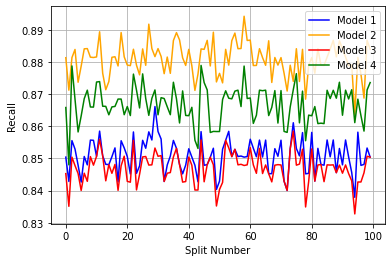

In [255]:
x= [i for i in range(0,100)]
plt.plot(x, md1_results, color = 'blue')
plt.plot(x, md2_results, color = 'orange')
plt.plot(x, md3_results, color = 'red')
plt.plot(x, md4_results, color = 'green')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4'])
plt.grid()
plt.show();

In [ ]:
#Model 2, using the solver Liblinear and penalty L2 is the better out of model 1 and 2 based on recall values.
#Model 4, using the solver saga and penalty L2 is the better out of model 3 and 4 based on recall values.

In [256]:
#Min Max Scaler
scaler= MinMaxScaler()
telecom_train= scaler.fit_transform(telecom_train)
telecom_test= scaler.fit_transform(telecom_test)


#Model 1
#Building the linear model
m1= LogisticRegression(solver='liblinear', penalty='l2').fit(x_train, y_train)
#Predicting on the validation set
m1_pred= m1.predict_proba(x_val)[:,1]
#Setting 10% cut-off
m1_labels=np.where(m1_pred<0.10,0,1)
#Computing recall score and storing it
m1_recall= recall_score(y_val, m1_labels)


#Model 2
#Building the linear model
m2= LogisticRegression(solver='saga', penalty='l2').fit(x_train, y_train)
#Predicting on the validation set
m2_pred= m2.predict_proba(x_val)[:,1]
#Setting 10% cut-off
m2_labels=np.where(m2_pred<0.10,0,1)
#Computing recall score and storing it
m2_recall= recall_score(y_val, m2_labels)

print('Recall score for model 1:', m1_recall)
print('Recall score for model 2:', m2_recall)

Recall score for model 1: 0.9358974358974359
Recall score for model 2: 0.9230769230769231


In [ ]:
#Based on the recall values above, we would want to use model 1, that contains the solver liblinear and penalty l2!